# Testing MST Examples

In [1]:
import numpy as np
import math
import sympy
from itertools import product, combinations
import itertools
import networkx as nx
import matplotlib.pyplot as plt

import sympy
import cdd
import time

### Naive Circuit Enumeration

In [2]:
#####chase's naive alrogithm circuit code
#naive approach for enumerating C(A,B)
#Input: A_eq and B_ineq are (m_a x n) and (m x n) numpy arrays
#Output: list of circuits in C(A,B) given by n-dimensional numpy arrays
def enumerate_circuits(B_ineq, A_eq=None):
    B = sympy.Matrix(B_ineq)
    m,n = B.shape
    # print(B)
    r = 0
    if A_eq is not None:
        A = sympy.Matrix(A_eq)
        A, pivot_columns = A.rref()    #use reduced echelon form of A
        r = len(pivot_columns)         #r is the rank of A

    circuits = []
    pos_circs = []
    for I in itertools.combinations(range(m),n-r-1):
        B_I = B[I,:]
        
        if A_eq is not None:
            D = A.col_join(B_I)
        else:
            D = B_I  
            
        ker_D = D.nullspace()
        if len(ker_D) == 1:   #circuit direction is found iff null space of D is one-dimensional
            print('B_I rows',B_I)
            g = np.array(ker_D[0]).flatten()
            ###I think the .q implies the matrices need to come in integers/rationals? 
            ###It got upset when I had a float as an entry
            g = g*sympy.lcm([g[i].q for i in range(n) if g[i] != 0]) #normalize to coprime integers
            print(f'circuit: {g}')
            g_is_duplicate = False
            for y in circuits:
                if np.array_equal(y, g):
                    g_is_duplicate = True
            if not g_is_duplicate:
                circuits.append(g)
                pos_circs.append(g)
                print('circuit was added')
                ###commented out since don't necessarily care about having both directions
                circuits.append(-1*g)
                
    return (np.array(circuits),np.array(pos_circs))

In [2]:
def determine_y_vars(m,sign=None):
    y_vars = []
    if sign is None:
       for i in range(m):
           y_vars.append([i, 1])
           y_vars.append([i, -1])
    else:
        for i in range(m):
            s = sign[i]
            if s is None:
                y_vars.append([i, 1])
                y_vars.append([i, -1])
            elif s > 0:
                y_vars.append([i, 1])
            elif s < 0:
                y_vars.append([i, -1])
    return y_vars

In [3]:
def build_augmented_matrix(B, y_vars, A=None):
    m_B, n = B.shape
    n_y_vars = len(y_vars)
    
    M = np.concatenate((B, np.zeros((m_B, n_y_vars), dtype=int)), axis=1)
    for j in range(n_y_vars):
        i = y_vars[j][0]
        M[i][n+j] = -1*y_vars[j][1]
    
    if A is not None:
        m_A = A.shape[0]
        A_aug = np.concatenate((A, np.zeros((m_A, n_y_vars), dtype=int)), axis=1)
        M = np.concatenate((A_aug, M), axis=0)
        
    return M

In [4]:
def poly_circs(B_ineq, A_eq=None, sign=None):
    A = A_eq
    B = B_ineq
    m_B,n = B.shape
    m_a = 0
    if A is not None:
        m_a = A.shape[0]
    
    y_vars = determine_y_vars(m_B, sign=sign)
    n_y_vars = len(y_vars)
    
    #build constraint matrix M for conic polyhedral model Mr >= 0,
    #where first column of M is the r.h.s. vector 0.
    M = build_augmented_matrix(B, y_vars, A=A)
    M = np.concatenate((M, -1*M))
    I_y = np.concatenate((np.zeros((n_y_vars, n)), np.eye(n_y_vars)), axis=1).astype(int)
    M = np.concatenate((M, I_y))
    M = np.concatenate((np.zeros((2*m_a + 2*m_B + n_y_vars, 1), dtype=int), M), axis=1)
    
    #use cdd to enumerate extreme rays of the cone
    mat = cdd.Matrix(M, number_type='fraction')
    # mat = cdd.Matrix(M, number_type = 'float')
    mat.rep_type = cdd.RepType.INEQUALITY
    poly = cdd.Polyhedron(mat)
    rays = np.array(poly.get_generators())
    # print(rays)

    # obtain circuits from extreme rays
    circuits = []
    num_rays = rays.shape[0]
    for i in range(num_rays):
        g = rays[i,1:n+1]
        if not np.array_equal(g, np.zeros(n)):
            g = g*sympy.lcm([g[j].denominator for j in range(n) if g[j] != 0]) #normalize
            circuits.append(g)  
    return circuits

In [7]:
B_2 = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0],
                [0,0,0,0,0,0,1],[1,0,1,0,0,0,0],[1,0,0,1,0,0,0],[1,0,0,0,1,0,0],[0,0,1,0,0,1,0],[0,0,1,0,0,0,0],
                [0,0,0,0,0,1,1],[1,0,1,1,1,0,0],[1,0,1,0,1,0,0],[0,0,0,0,0,1,1],[0,0,1,1,1,1,1]])
all_circuits_2, init_circuits_2 = enumerate_circuits(B_2)

B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0]])
circuit: [0 0 0 0 0 0 1]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1]])
circuit: [0 0 0 0 0 1 0]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0]])
circuit: [0 0 0 0 0 0 1]
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 1]])
circuit: [0 0 0 0 0 -1 1]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 1]])
circuit: [0 0 0 0 0 -1 1]
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0],

In [8]:
init_circuits_2

array([[0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, -1, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, -1, 0, 1],
       [0, 0, 0, 0, -1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, -1, 0, 0, 1],
       [0, 0, 0, -1, 0, 1, 0],
       [0, 0, 0, -1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, -1, 0, 0, 0, 1],
       [0, 0, -1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, -1, 1],
       [0, 0, -1, 0, 1, 0, 0],
       [0, 0, -1, 0, 1, 1, 0],
       [0, 0, 1, 0, -1, -1, 1],
       [0, 0, -1, 1, 0, 0, 0],
       [0, 0, -1, 1, 0, 1, 0],
       [0, 0, 1, -1, 0, -1, 1],
       [0, 0, -1, -1, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [-1, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, -1, 0, 1],
       [1, 0, 0, 0, -1, 1, 0],
       [-1, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, -1, 0, 0, 1],
       [1, 0, 0, -1, 0, 1, 0],
       [-1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, -1, 1, 0, 0],
       [-1, 0, 0, -1, 1, 0, 0],
       [1, 

In [9]:
mst_test_2 = nx.Graph()
mst_test_2.add_edges_from(([(1,2),(1,5),(2,3),(2,4),(2,5),(3,4),(4,5)]))

In [16]:
def color_graph_2(graph, circuit):
    edges = graph.edges
    
    for (i,j) in edges:
        # print(f'({i},{j})')
        graph[i][j]['color'] = (0,0,0)
        graph[i][j]['weight'] = 1
        if ((i == 1 and j ==2)or (i==2 and j ==1))and circuit[0] !=0:
            if circuit[0] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[0])*5
        elif ((i == 1 and j ==5)or (i==5 and j ==1))and circuit[1] !=0:
            if circuit[1] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[1])*5
        elif ((i == 2 and j ==3)or (i==3 and j ==2))and circuit[2] !=0:
            if circuit[2] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[2])*5
        elif ((i == 2 and j ==4)or (i==4 and j ==2))and circuit[3] !=0:
            if circuit[3] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[3])*5
        elif ((i == 2 and j ==5)or (i==5 and j ==2))and circuit[4] !=0:
            if circuit[4] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[4])*5
        elif ((i == 3 and j ==4)or (i==4 and j ==3))and circuit[5] !=0:
            if circuit[5] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[5])*5
        elif ((i == 4 and j ==5)or (i==5 and j ==4))and circuit[6] !=0:
            if circuit[6] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[6])*5
                    
    return graph

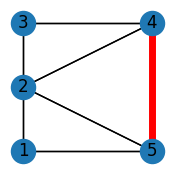

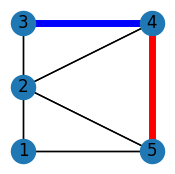

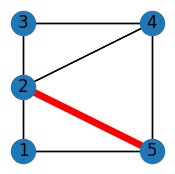

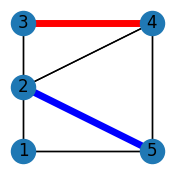

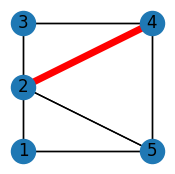

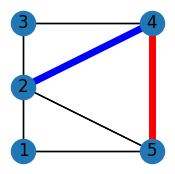

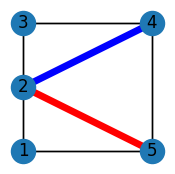

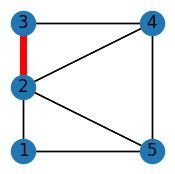

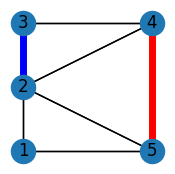

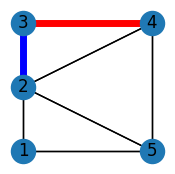

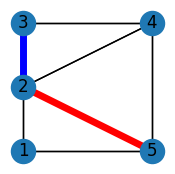

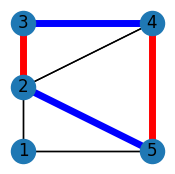

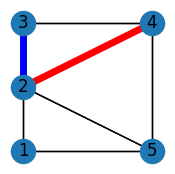

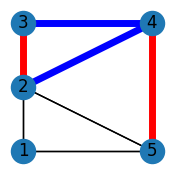

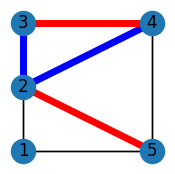

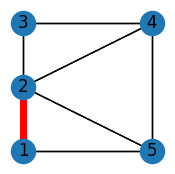

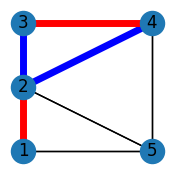

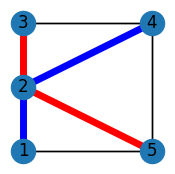

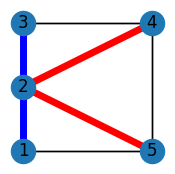

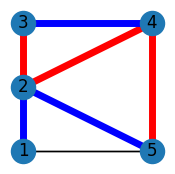

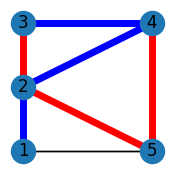

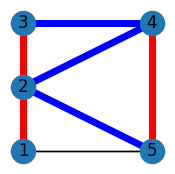

In [26]:
for circuit in init_circuits_2:
    if (np.dot(circuit,circuit) <=2) or (sum(circuit)==0):
        mst_color = color_graph_2(mst_test_2, circuit)
        colors = [mst_color[u][v]['color'] for u,v in mst_color.edges]
        widths = nx.get_edge_attributes(mst_color, 'weight')
        pos = nx.bipartite_layout(mst_color, [1,2,3])
        fig, ax = plt.subplots(figsize=(2,2))
        # pos = nx.rescale_layout(pos_init, scale=0.25)
        nx.draw(mst_color,pos, edge_color=colors,with_labels = True, ax = ax)
        nx.draw_networkx_edges(mst_color,pos,
                        edge_color=colors,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                          ax = ax)
        # plt.figure(figsize=(0.25,0.25))
        plt.show()

In [21]:
A = np.ones((1,5),int)
B = np.array([[1,0,0,0,0,1,1,0],[0,1,0,0,0,0,1,0],[0,0,1,0,0,1,0,1], [0,0,0,1,0,0,1,1],[0,0,0,0,1,0,0,1]]).transpose()
all_circuits, init_circuits = enumerate_circuits(B)

B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0]])
circuit: [0 0 0 0 1]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1]])
circuit: [0 0 0 1 0]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 1, 0]])
circuit: [0 0 0 0 1]
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 1, 1]])
circuit: [0 0 0 -1 1]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])
circuit: [0 0 1 0 0]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 1, 0, 0]])
circuit: [0 0 0 0 1]
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 1, 1, 1]])
circuit: [0 0 -1 0 1]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 1, 0, 0]])
circuit: [0 0 0 1 0]
B_I rows Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [

In [28]:
mst_test = nx.Graph()
mst_test.add_edges_from(([(1,2),(1,4),(2,3),(2,4),(3,4)]))

In [27]:
def color_graph(graph, circuit):
    edges = graph.edges
    
    for (i,j) in edges:
        # print(f'({i},{j})')
        graph[i][j]['color'] = (0,0,0)
        graph[i][j]['weight'] = 1
        if ((i == 1 and j ==2) or (i==2 and j==1)) and circuit[0] !=0:
            if circuit[0] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[0])*5
        elif((i == 1 and j ==4) or (i==4 and j==1)) and circuit[1] !=0:
            if circuit[1] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[1])*5
        elif ((i == 2 and j ==3) or (i==3 and j==2)) and circuit[2] !=0:
            if circuit[2] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[2])*5
        elif ((i == 2 and j ==4) or (i==4 and j==2)) and circuit[3] !=0:
            if circuit[3] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[3])*5
        elif ((i == 3 and j ==4) or (i==4 and j==3)) and circuit[4] !=0:
            if circuit[4] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[4])*5
        
                    
    return graph

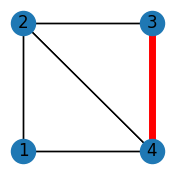

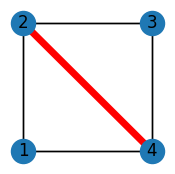

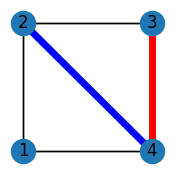

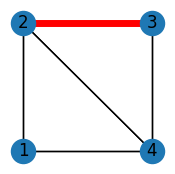

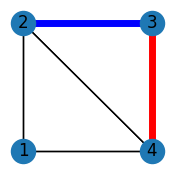

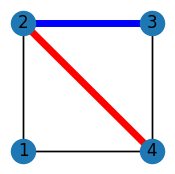

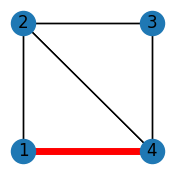

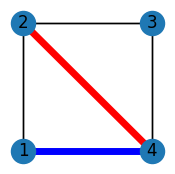

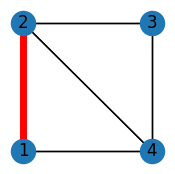

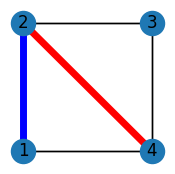

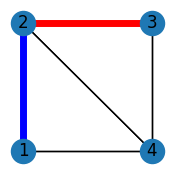

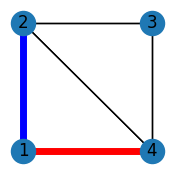

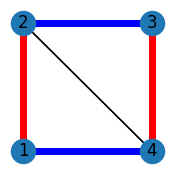

In [29]:
for circuit in init_circuits:
    if (np.dot(circuit,circuit) <=2) or (sum(circuit)==0):
        mst_color = color_graph(mst_test, circuit)
        colors = [mst_color[u][v]['color'] for u,v in mst_color.edges]
        widths = nx.get_edge_attributes(mst_color, 'weight')
        pos = nx.bipartite_layout(mst_color, [1,2])
        fig, ax = plt.subplots(figsize=(2,2))
        # pos = nx.rescale_layout(pos_init, scale=0.25)
        nx.draw(mst_color,pos, edge_color=colors,with_labels = True, ax = ax)
        nx.draw_networkx_edges(mst_color,pos,
                        edge_color=colors,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                          ax = ax)
         # plt.figure(figsize=(0.25,0.25))
        plt.show()

In [3]:
mst_3 = nx.Graph()
mst_3.add_edges_from([(1,2),(1,7),(2,3),(3,4),(3,5),(4,5),(5,6),(6,7)])
# nx.draw(mst_3)

In [ ]:
B_3 = np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1],[1,0,1,0,0,0,0,0],[1,1,0,0,0,0,0,0],
                [0,0,1,1,0,0,0,0],[0,0,1,0,1,0,0,0],[0,0,0,1,1,1,0,0],[0,0,0,0,0,1,1,0],[0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,1],[0,0,0,0,1,0,1,0],[1,0,1,1,0,0,0,0],[1,0,1,0,1,0,0,0],[1,1,1,0,0,0,0,0],
                [0,0,1,1,1,1,0,0],[0,0,1,0,1,0,1,0],[0,0,0,1,1,1,1,0],[0,0,0,0,1,0,1,1],[0,0,0,0,0,1,1,1],
                [1,0,1,1,1,1,0,0],[1,1,1,1,0,0,0,0],[0,0,1,1,1,1,1,0],[0,0,0,1,1,1,1,1],[1,0,1,1,1,1,1,0],
                [1,1,1,1,1,1,0,0],[0,0,1,1,1,1,1,1],[1,1,1,1,0,0,1,1],[1,1,1,0,1,0,1,1],[1,1,0,0,0,1,1,1],
                [0,1,0,1,1,1,1,1]])
all_circuitss_3, init_ciruits_3 = enumerate_circuits(B_3)
# circuits_3 = poly_circs(B_3)

B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0]])
circuit: [0 0 0 0 0 0 0 1]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1]])
circuit: [0 0 0 0 0 0 1 0]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 1, 0]])
circuit: [0 0 0 0 0 0 0 1]
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1]])
circuit: [0 0 0 0 0 0 -1 1]
circuit was added
B_I rows Matrix([[1, 0, 0, 0, 0, 0, 0

In [ ]:
def color_graph_3(graph, circuit):
    edges = graph.edges
    
    for (i,j) in edges:
        # print(f'({i},{j})')
        graph[i][j]['color'] = (0,0,0)
        graph[i][j]['weight'] = 1
        if ((i == 1 and j ==2)or (i==2 and j ==1))and circuit[0] !=0:
            if circuit[0] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[0])*5
        elif ((i == 1 and j ==7) or (i==7 and j ==1))and circuit[1] !=0:
            if circuit[1] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[1])*5
        elif ((i == 2 and j ==3)or (i==3 and j ==2))and circuit[2] !=0:
            if circuit[2] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[2])*5
        elif ((i == 3 and j ==4)or (i==4 and j ==3))and circuit[3] !=0:
            if circuit[3] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[3])*5
        elif ((i == 3 and j ==5)or (i==5 and j ==3))and circuit[4] !=0:
            if circuit[4] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[4])*5
        elif ((i == 4 and j ==4)or (i==4 and j ==3))and circuit[5] !=0:
            if circuit[5] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[5])*5
        elif ((i == 4 and j ==5)or (i==5 and j ==4))and circuit[6] !=0:
            if circuit[6] < 0:
                graph[i][j]['color'] = (0,0,1)
            else:
                graph[i][j]['color'] = (1,0,0)
            graph[i][j]['weight'] = abs(circuit[6])*5
                    
    return graph

In [ ]:
for circuit in init_circuits_3:
    if (np.dot(circuit,circuit) <=2) or (sum(circuit)==0):
        mst_color = color_graph(mst_3, circuit)
        colors = [mst_color[u][v]['color'] for u,v in mst_color.edges]
        widths = nx.get_edge_attributes(mst_color, 'weight')
        pos = nx.bipartite_layout(mst_color, [1,2])
        fig, ax = plt.subplots(figsize=(2,2))
        # pos = nx.rescale_layout(pos_init, scale=0.25)
        nx.draw(mst_color,pos, edge_color=colors,with_labels = True, ax = ax)
        nx.draw_networkx_edges(mst_color,pos,
                        edge_color=colors,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                          ax = ax)
         # plt.figure(figsize=(0.25,0.25))
        plt.show()

In [37]:
###construct matrix for matroid independent matroid polytope H-rep
def construct_B_ind_mat(columns):
    #lower bound (orientation stuff)
    B = -1*np.identity(columns,dtype = int)

    #other subset inequalities (related to rank function)
    for k in range(1,columns+1):
        x_combs = np.array([np.array([1 if i in comb else 0 for i in range(columns)],dtype = int) for comb in combinations(np.arange(columns), k)],dtype = int)
        B = np.concatenate((B,x_combs), axis = 0)

    return B;

In [38]:
elements = 5
B_mat = construct_B_ind_mat(elements)
all_circuits_mat, init_circuits_mat = enumerate_circuits(B_mat)

B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 0, 0, -1, 0]])
circuit: [0 0 0 0 1]
circuit was added
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 0, 0, 0, -1]])
circuit: [0 0 0 1 0]
circuit was added
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 0, 0, 1, 0]])
circuit: [0 0 0 0 1]
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 0, 0, 0, 1]])
circuit: [0 0 0 1 0]
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [1, 0, 0, 1, 0]])
circuit: [0 0 0 0 1]
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [1, 0, 0, 0, 1]])
circuit: [0 0 0 1 0]
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 1, 0, 1, 0]])
circuit: [0 0 0 0 1]
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 1, 0, 0, 1]])
circuit: [0 0 0 1 0]
B_I rows Matrix([[-1, 0, 0, 0, 0], [0, -1, 0, 0, 0], [0, 0, -1, 0, 0], [0, 0, 1, 1

In [30]:
# init_circuits
# mst_test = nx.Graph()
# mst_test.add_edges_from(([(1,2),(1,4),(2,3),(2,4),(3,4)]))

# for circuit in init_circuits_mat:
#     mst_color = color_graph(mst_test, circuit)
#     colors = [mst_color[u][v]['color'] for u,v in mst_color.edges]
#     widths = nx.get_edge_attributes(mst_color, 'weight')
#     pos = nx.bipartite_layout(mst_color, [1,2])
#     fig, ax = plt.subplots(figsize=(2,2))
#     nx.draw(mst_color,pos, edge_color=colors,with_labels = True, ax = ax)
#     nx.draw_networkx_edges(mst_color,pos,
#                         edge_color=colors,
#                        edgelist = widths.keys(),
#                        width=list(widths.values()),
#                           ax = ax)
#     plt.show()

In [31]:
# init_circuits_mat

In [32]:
#